## Import Modules & Libraries

In [3]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
from collections import Counter
np.random.seed(42)

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.datasets import fetch_lfw_people
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Resizing
from tensorflow_privacy.privacy.optimizers.dp_optimizer_keras import DPKerasAdamOptimizer
from tensorflow.keras.constraints import MaxNorm
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import utils
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet50

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import tenseal as ts
import base64

## Import Dataset

In [15]:
faces = fetch_lfw_people(min_faces_per_person=100, resize=0.4)
image_count = faces.images.shape[0]
image_height = faces.images.shape[1]
image_width = faces.images.shape[2]
class_count = len(faces.target_names)

print(faces.target_names)
print(faces.images.shape)

['Colin Powell' 'Donald Rumsfeld' 'George W Bush' 'Gerhard Schroeder'
 'Tony Blair']
(1140, 50, 37)


## Differential Privacy with TensorFlow

In [16]:
X = faces.images / 255.0
y = faces.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

X_train = X_train.reshape(-1, X_train.shape[1] * X_train.shape[2])
X_test = X_test.reshape(-1, X_test.shape[1] * X_test.shape[2])

In [17]:
def add_noise_to_data(data, noise_factor=0.3):
    noise = noise_factor * np.random.normal(loc=0.0, scale=1.0, size=data.shape)
    noisy_data = data + noise
    noisy_data = np.clip(noisy_data, 0.0, 1.0)
    return noisy_data

X_train_noisy = add_noise_to_data(X_train, noise_factor=0.3)
X_test_noisy = add_noise_to_data(X_test, noise_factor=0.3)

In [18]:
l2_norm_clip = 1.0
noise_multiplier = 0.8
batch_size = 64
num_microbatches = 1
learning_rate = 0.01

In [20]:
optimizer = DPKerasAdamOptimizer(
    l2_norm_clip=l2_norm_clip,
    noise_multiplier=noise_multiplier,
    num_microbatches=num_microbatches,
    learning_rate=learning_rate
)

model = Sequential([
    Flatten(input_shape=(X_train.shape[1],)),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(len(faces.target_names), activation='softmax')
])

model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = model.fit(X_train_noisy, y_train, epochs=20, batch_size=batch_size, validation_data=(X_test_noisy, y_test))

Epoch 1/20
9/9 [==============================] - 3s 89ms/step - loss: 1.6859 - accuracy: 0.2333 - val_loss: 1.5306 - val_accuracy: 0.3947
Epoch 2/20
9/9 [==============================] - 1s 58ms/step - loss: 1.7710 - accuracy: 0.3053 - val_loss: 1.5596 - val_accuracy: 0.4491
Epoch 3/20
9/9 [==============================] - 1s 57ms/step - loss: 2.0365 - accuracy: 0.2982 - val_loss: 1.6028 - val_accuracy: 0.4474
Epoch 4/20
9/9 [==============================] - 1s 68ms/step - loss: 2.3062 - accuracy: 0.3140 - val_loss: 1.6093 - val_accuracy: 0.4158
Epoch 5/20
9/9 [==============================] - 1s 101ms/step - loss: 2.3520 - accuracy: 0.3070 - val_loss: 1.6238 - val_accuracy: 0.3947
Epoch 6/20
9/9 [==============================] - 0s 36ms/step - loss: 2.8703 - accuracy: 0.2842 - val_loss: 1.7070 - val_accuracy: 0.3211
Epoch 7/20
9/9 [==============================] - 0s 52ms/step - loss: 3.0293 - accuracy: 0.2772 - val_loss: 1.8381 - val_accuracy: 0.2772
Epoch 8/20
9/9 [==========

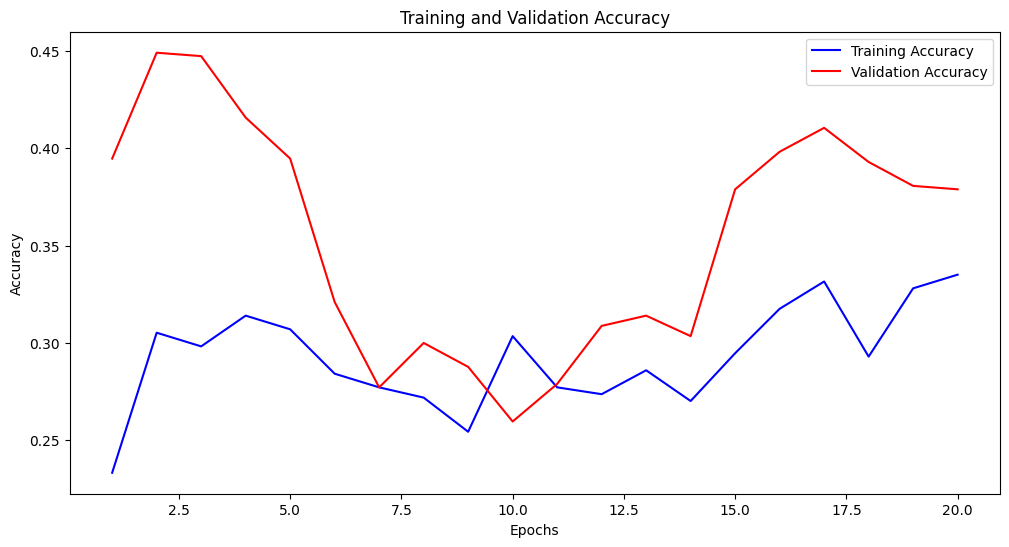

In [22]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
epochs = range(1, len(accuracy) + 1)

plt.figure(figsize=(12, 6))
plt.plot(epochs, accuracy, 'b', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## Homomorphic Encryption

In [23]:
def write_data(file_name, data):
    if type(data) == bytes:
        data = base64.b64encode(data)
    with open(file_name, 'wb') as f:
        f.write(data)

def read_data(file_name):
    with open(file_name, "rb") as f:
        data = f.read()
    return base64.b64decode(data)

In [24]:
context = ts.context(
    ts.SCHEME_TYPE.CKKS,
    poly_modulus_degree=16384,
    coeff_mod_bit_sizes=[60, 40, 40, 60]
)

In [26]:
context.generate_galois_keys()
context.global_scale = 2**40
secret_context = context.serialize(save_secret_key=True)
public_context = context.serialize()
write_data("secret.txt", secret_context)
write_data("public.txt", public_context)

context = ts.context_from(read_data("secret.txt"))
context_public = ts.context_from(read_data("public.txt"))

In [27]:
X_train, X_test, y_train, y_test = train_test_split(faces.data, faces.target, test_size=0.2, stratify=faces.target, random_state=42)

onehot_encoder = OneHotEncoder(sparse=False, categories='auto')
y_train_onehot = onehot_encoder.fit_transform(y_train.reshape(-1, 1))
y_test_onehot = onehot_encoder.transform(y_test.reshape(-1, 1))

enc_X_train = [ts.ckks_vector(context, row.tolist()) for row in X_train]
enc_X_test = [ts.ckks_vector(context, row.tolist()) for row in X_test]

In [32]:
model = Sequential()
model.add(Flatten(input_shape=(image_width * image_height,)))
model.add(Dense(512, activation='relu'))
model.add(Dense(class_count, activation='softmax'))

model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(
    np.array([vec.decrypt() for vec in enc_X_train]), y_train_onehot,
    epochs=20,
    validation_data=(np.array([vec.decrypt() for vec in enc_X_test]), y_test_onehot),
    shuffle=True
)

Epoch 1/20
29/29 [==============================] - 1s 16ms/step - loss: 2.4079 - accuracy: 0.3618 - val_loss: 1.4250 - val_accuracy: 0.5088
Epoch 2/20
29/29 [==============================] - 0s 10ms/step - loss: 1.2716 - accuracy: 0.5329 - val_loss: 1.2419 - val_accuracy: 0.5263
Epoch 3/20
29/29 [==============================] - 0s 10ms/step - loss: 1.1428 - accuracy: 0.5735 - val_loss: 1.1562 - val_accuracy: 0.5351
Epoch 4/20
29/29 [==============================] - 0s 11ms/step - loss: 1.0711 - accuracy: 0.6031 - val_loss: 1.2260 - val_accuracy: 0.5746
Epoch 5/20
29/29 [==============================] - 0s 10ms/step - loss: 1.0537 - accuracy: 0.6261 - val_loss: 1.0234 - val_accuracy: 0.6579
Epoch 6/20
29/29 [==============================] - 0s 11ms/step - loss: 1.0341 - accuracy: 0.6020 - val_loss: 1.1464 - val_accuracy: 0.6623
Epoch 7/20
29/29 [==============================] - 0s 13ms/step - loss: 0.9243 - accuracy: 0.6897 - val_loss: 1.0237 - val_accuracy: 0.6140
Epoch 8/20
29

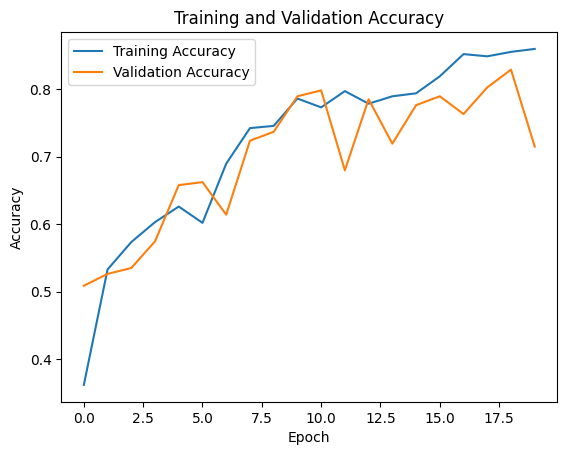

In [33]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

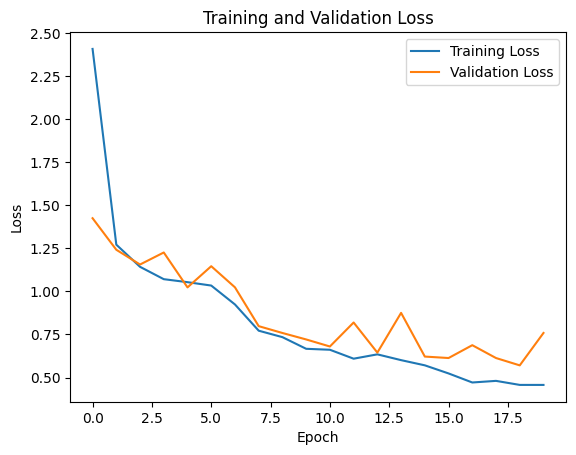

In [34]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()